# 1. Setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'Tamil'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'
test_dir_v2 = f'Data/{language}-V2-Test'

In [3]:
character_df_fp = f'Data/Characters/Characters-{language}.csv'

In [4]:
cpu_count = 8 #os.cpu_count()
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

8
cuda


# 2. Define character class

In [5]:
character_df = pd.read_csv(character_df_fp)
print(character_df.shape)
character_df.head()

(247, 3)


,Character,Consonant,Glyph
0,அ,-,-
1,ஆ,-,ா
2,இ,-,ி
3,ஈ,-,ீ
4,உ,-,ு


In [6]:
#character_df[character_df['Consonant']=="-"]

In [7]:
characters = set()
for character in character_df['Character'].values:
    characters.update(list(character))
characters = ["-"] + sorted(list(characters))
print(len(characters))
print(characters)

44
['-', 'ஃ', 'அ', 'ஆ', 'இ', 'ஈ', 'உ', 'ஊ', 'எ', 'ஏ', 'ஐ', 'ஒ', 'ஓ', 'ஔ', 'க', 'ங', 'ச', 'ஞ', 'ட', 'ண', 'த', 'ந', 'ன', 'ப', 'ம', 'ய', 'ர', 'ற', 'ல', 'ள', 'ழ', 'வ', 'ா', 'ி', 'ீ', 'ு', 'ூ', 'ெ', 'ே', 'ை', 'ொ', 'ோ', 'ௌ', '்']


In [8]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'ஃ', 2: 'அ', 3: 'ஆ', 4: 'இ', 5: 'ஈ', 6: 'உ', 7: 'ஊ', 8: 'எ', 9: 'ஏ', 10: 'ஐ', 11: 'ஒ', 12: 'ஓ', 13: 'ஔ', 14: 'க', 15: 'ங', 16: 'ச', 17: 'ஞ', 18: 'ட', 19: 'ண', 20: 'த', 21: 'ந', 22: 'ன', 23: 'ப', 24: 'ம', 25: 'ய', 26: 'ர', 27: 'ற', 28: 'ல', 29: 'ள', 30: 'ழ', 31: 'வ', 32: 'ா', 33: 'ி', 34: 'ீ', 35: 'ு', 36: 'ூ', 37: 'ெ', 38: 'ே', 39: 'ை', 40: 'ொ', 41: 'ோ', 42: 'ௌ', 43: '்'}
{'-': 0, 'ஃ': 1, 'அ': 2, 'ஆ': 3, 'இ': 4, 'ஈ': 5, 'உ': 6, 'ஊ': 7, 'எ': 8, 'ஏ': 9, 'ஐ': 10, 'ஒ': 11, 'ஓ': 12, 'ஔ': 13, 'க': 14, 'ங': 15, 'ச': 16, 'ஞ': 17, 'ட': 18, 'ண': 19, 'த': 20, 'ந': 21, 'ன': 22, 'ப': 23, 'ம': 24, 'ய': 25, 'ர': 26, 'ற': 27, 'ல': 28, 'ள': 29, 'ழ': 30, 'வ': 31, 'ா': 32, 'ி': 33, 'ீ': 34, 'ு': 35, 'ூ': 36, 'ெ': 37, 'ே': 38, 'ை': 39, 'ொ': 40, 'ோ': 41, 'ௌ': 42, '்': 43}


# 3. Define data loader

In [9]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [10]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

# 4. Define model

In [11]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [12]:
for p in resnet.parameters():
    p.requires_grad = False

In [13]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

# 5. Make predictions

In [14]:
batch_size = 64
rnn_hidden_size = 256

In [15]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir)
testset_v2 = IndianSceneTextDataset(test_dir_v2)

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader_v2 = DataLoader(testset_v2, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

In [16]:
model_path = f'Models/{language}-Unicode-e30.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)
crnn.eval()

CRNN(
  (dp1): Dropout(p=0.5, inplace=False)
  (dp2): Dropout(p=0.5, inplace=False)
  (dp3): Dropout(p=0.5, inplace=False)
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [17]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [18]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [19]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)
test_result_v2 = make_predictions(test_loader_v2)

In [20]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
print(test_result_v2.shape)
train_result.head()

(500000, 3)
(5000, 3)
(5000, 3)
(2500, 3)


,image_fn,actual,prediction
0,உள்ளனர்_11_2633_4.jpg,உள்ளனர்,உள---்்ள-ன-ர்
1,உள்ளனர்_23_2236_0.jpg,உள்ளனர்,உள---்ளளனன-ர்
2,பழ_22_1257_0.jpg,பழ,பழ-----------
3,ஊசி_6_2725_6.jpg,ஊசி,ஊ--------ச--ி
4,பத்மன்_18_4216_5.jpg,பத்மன்,பதத--்ம----ன்


In [21]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [22]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)
test_result_v2['prediction_corrected'] = test_result_v2['prediction'].apply(correct_prediction)

In [23]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)
test_result_v2['actual_length'] = test_result_v2['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)
test_result_v2['prediction_length'] = test_result_v2['prediction_corrected'].apply(len)

In [24]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [25]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)
test_result_v2['edit_distance'] = test_result_v2.apply(levenshteinDistance, axis=1)

# 6. Evaluate the model

In [26]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
test_accuracy_v2 = accuracy_score(test_result_v2['actual'], test_result_v2['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2)

0.836646 0.768 0.8128 0.948


In [27]:
accuracy_df = []
for max_edit_distance in range(4+1):
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    test_accuracy_v2 = (test_result_v2['edit_distance'] <= max_edit_distance).sum() / len(test_result_v2)
    accuracy_df.append([max_edit_distance, train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2])
columns=['Max-Edit-Distance', 'Train-Accuracy', 'Val-Accuracy', 'Test-Accuracy', 'V2-Test-Accuracy']
accuracy_df = pd.DataFrame(accuracy_df, columns=columns)
accuracy_df.to_csv(f'Results/{language}.csv', index=False)
accuracy_df

,Max-Edit-Distance,Train-Accuracy,Val-Accuracy,Test-Accuracy,V2-Test-Accuracy
0,0,0.836646,0.7680,0.8128,0.9480
1,1,0.893500,0.8316,0.8758,0.9812
2,2,0.930516,0.8874,0.9164,0.9892
3,3,0.959976,0.9362,0.9492,0.9936
4,4,0.975304,0.9588,0.9674,0.9976


In [28]:
test_result['edit_distance'].describe()

count    5000.000000
mean        0.522400
std         1.388194
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        12.000000
Name: edit_distance, dtype: float64

In [34]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=1):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
    elif split == "Test-V2":
        result = test_result_v2
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        if split == 'Test-V2':
            image_fp = f'Data/{language}-V2-Test/{row["image_fn"]}'
        else:
            image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

In [35]:
#visualize_misclassifications('Train')

In [36]:
#visualize_misclassifications('Val')

('Actual:', 'பத்மன்', 'Prediction:', 'பத-----ங்க--்', 'Prediction Corrected:', 'பதங்க்')


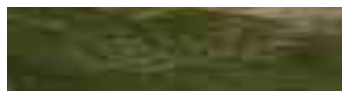

('Actual:', 'படிகமானதல்ல', 'Prediction:', 'படிகமாாவதலலலல', 'Prediction Corrected:', 'படிகமாவதல')


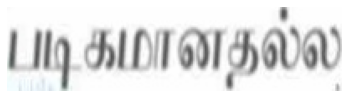

('Actual:', 'மகதலா', 'Prediction:', 'மக--்த--ல--ாா', 'Prediction Corrected:', 'மக்தலா')


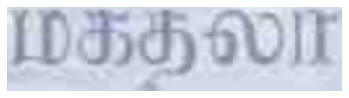

('Actual:', 'காரணமாக', 'Prediction:', 'சர---ண--மாாக-', 'Prediction Corrected:', 'சரணமாக')


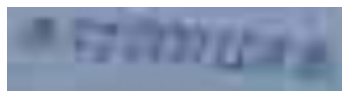

('Actual:', 'அல்லது', 'Prediction:', 'வல----்ல--த-ு', 'Prediction Corrected:', 'வல்லது')


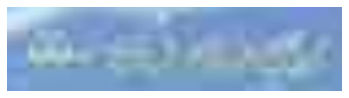

('Actual:', 'மரணமடைந்தார்', 'Prediction:', 'பள---டைந்தூர்', 'Prediction Corrected:', 'பளடைந்தூர்')


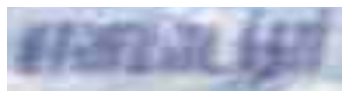

('Actual:', 'பிரசின', 'Prediction:', 'பி-ர--சி-----', 'Prediction Corrected:', 'பிரசி')


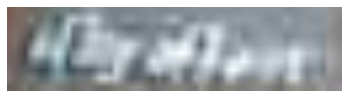

('Actual:', 'ஓவரூர்', 'Prediction:', 'என-----------', 'Prediction Corrected:', 'என')


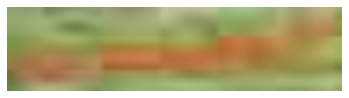

('Actual:', 'தரம்', 'Prediction:', 'தல---------ம்', 'Prediction Corrected:', 'தலம்')


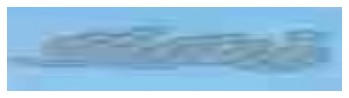

('Actual:', 'இரணியல்', 'Prediction:', 'இரர--வாாய--ல்', 'Prediction Corrected:', 'இரவாயல்')


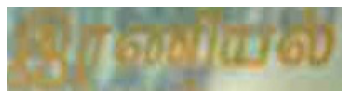

('Actual:', 'வந்தனர்', 'Prediction:', 'வங--்்க-வ--ர்', 'Prediction Corrected:', 'வங்கவர்')


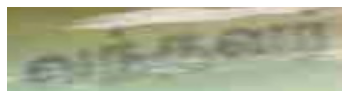

('Actual:', 'இல', 'Prediction:', 'அல----------்', 'Prediction Corrected:', 'அல்')


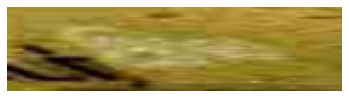

('Actual:', 'அணி', 'Prediction:', 'என-----------', 'Prediction Corrected:', 'என')


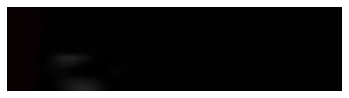

('Actual:', 'ஊரக', 'Prediction:', 'கர-------க---', 'Prediction Corrected:', 'கரக')


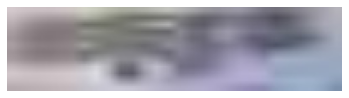

('Actual:', 'வழங்குவதாகஅரச', 'Prediction:', 'வழங்குரககாகல்', 'Prediction Corrected:', 'வழங்குரகாகல்')


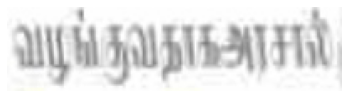

('Actual:', 'வனப்பு', 'Prediction:', 'வல------ப்ப-ு', 'Prediction Corrected:', 'வலப்பு')


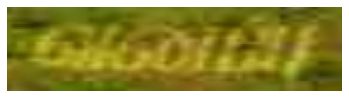

('Actual:', 'என', 'Prediction:', 'வன-----------', 'Prediction Corrected:', 'வன')


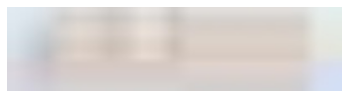

('Actual:', 'கல', 'Prediction:', 'சி-----------', 'Prediction Corrected:', 'சி')


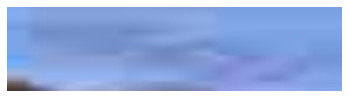

('Actual:', 'வட்ட', 'Prediction:', 'கஃ---------ப்', 'Prediction Corrected:', 'கஃப்')


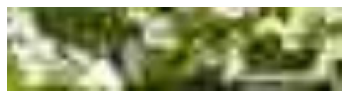

('Actual:', 'அழைத்தனர்', 'Prediction:', 'கர----்----ன்', 'Prediction Corrected:', 'கர்ன்')


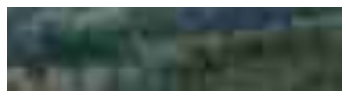

In [37]:
visualize_misclassifications('Test')

('Actual:', 'உபதேசங்கள்', 'Prediction:', 'உப--தெச-ங்கள்', 'Prediction Corrected:', 'உபதெசங்கள்')


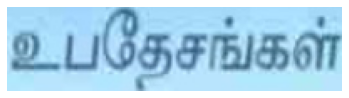

('Actual:', 'மரபணு', 'Prediction:', 'மர---ய--ண---ு', 'Prediction Corrected:', 'மரயணு')


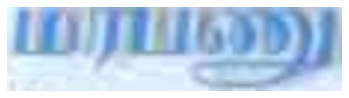

('Actual:', 'வழங்குவதாகஅரச', 'Prediction:', 'வழங்குரககாகல்', 'Prediction Corrected:', 'வழங்குரகாகல்')


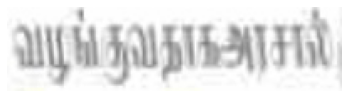

('Actual:', 'இருப்பவள்', 'Prediction:', 'இர-ுப்ப-வ--ன்', 'Prediction Corrected:', 'இருப்பவன்')


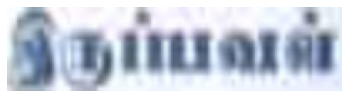

('Actual:', 'கயை', 'Prediction:', 'கண----------ை', 'Prediction Corrected:', 'கணை')


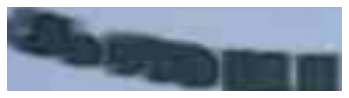

('Actual:', 'ஈடு', 'Prediction:', 'எட----------ு', 'Prediction Corrected:', 'எடு')


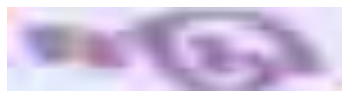

('Actual:', 'ஆதலால்', 'Prediction:', 'ஆக----ல-ாா-ல்', 'Prediction Corrected:', 'ஆகலால்')


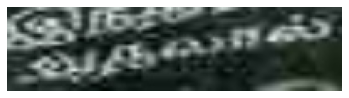

('Actual:', 'சிஏஎசு', 'Prediction:', 'சி--ள--ள--ச-ு', 'Prediction Corrected:', 'சிளளசு')


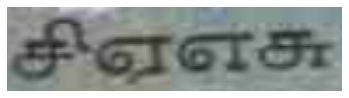

('Actual:', 'எனற', 'Prediction:', 'என------்-ற--', 'Prediction Corrected:', 'என்ற')


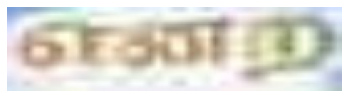

('Actual:', 'நடிகராக', 'Prediction:', 'நட---க-ராாகக-', 'Prediction Corrected:', 'நடகராக')


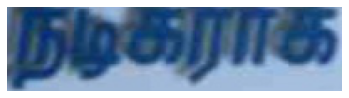

('Actual:', 'உரப்பயிர்கள்', 'Prediction:', 'உரர்பபயிர்கள்', 'Prediction Corrected:', 'உர்பயிர்கள்')


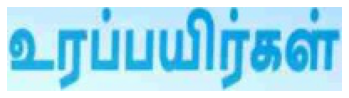

('Actual:', 'ஏரியல்', 'Prediction:', 'எர---ிிய---ல்', 'Prediction Corrected:', 'எரியல்')


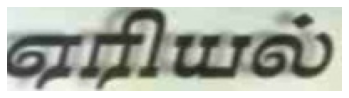

('Actual:', 'கணேசன்', 'Prediction:', 'கல----ேோச--ன்', 'Prediction Corrected:', 'கலேோசன்')


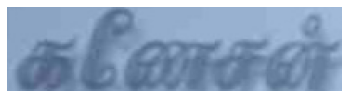

('Actual:', 'பறவைகள்', 'Prediction:', 'பே--வ-வ-கக-ல்', 'Prediction Corrected:', 'பேவவகல்')


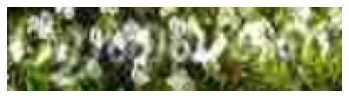

('Actual:', 'கஃபா', 'Prediction:', 'கட-----ப----ா', 'Prediction Corrected:', 'கடபா')


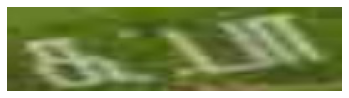

('Actual:', 'சரவணபெலகுளா', 'Prediction:', 'சரவணணிியகுுளா', 'Prediction Corrected:', 'சரவணியகுளா')


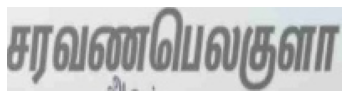

('Actual:', 'உரமிடுதல்', 'Prediction:', 'உய-----துத-ச்', 'Prediction Corrected:', 'உயதுதச்')


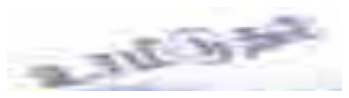

('Actual:', 'ஓவியங்கள்', 'Prediction:', 'ஓல--ிய-ங்க-ள்', 'Prediction Corrected:', 'ஓலியங்கள்')


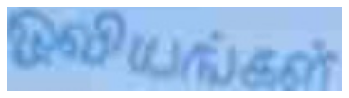

('Actual:', 'சீன', 'Prediction:', 'சன----------்', 'Prediction Corrected:', 'சன்')


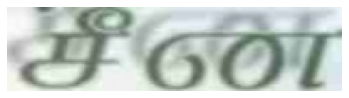

('Actual:', 'மணிரத்னம்', 'Prediction:', 'மண--ிிரத்ண-ம்', 'Prediction Corrected:', 'மணிரத்ணம்')


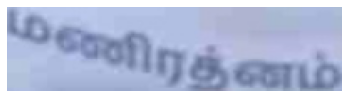

In [38]:
visualize_misclassifications('Test-V2')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/

In [40]:
#test_result